In [16]:
from dataclasses import dataclass

import torch
import torch.nn as nn
import math 
import torch.nn.functional as F
from dataclasses import dataclass
from jaxtyping import Float, Int
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from get_books import get_gutenberg_book, get_many_books
from transformers import AutoTokenizer  # for tokenization
from torch.nn import GELU  

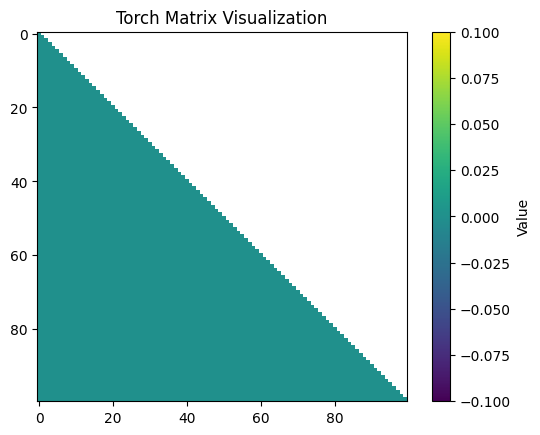

In [17]:
# def create_mask(n_context: int) -> Float[torch.Tensor, "n_context n_context"]:
def create_mask(n_context: int) -> torch.Tensor:
    mask = torch.zeros(n_context, n_context)
    indices = torch.triu_indices(n_context, n_context, offset=1)
    mask[indices[0], indices[1]] = float('-inf')
    
    return mask



# Create a random 5x5 matrix
M = create_mask(100)

# Convert to NumPy for visualization
M_np = M.numpy()

# Plot the matrix
plt.imshow(M_np, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value")  # Add a color bar
plt.title("Torch Matrix Visualization")
plt.show()

In [18]:
@dataclass
class GPTConfig:
	d_vocab: int = 10_000
	d_model: int = 128
	d_mlp: int = 512
	n_heads: int = 4
	d_head: int = 32
	n_layers: int = 6
	act_fn: type[nn.Module] = nn.ReLU

# note: the residual stream is `n_context` by `d_model`

# this is the row-wise (last dimension) softmax of x
# F.softmax(x, dim=-1)

class AttentionHead(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.W_Q = nn.Linear(cfg.d_model, cfg.d_head)
		self.W_K = nn.Linear(cfg.d_model, cfg.d_head)
		self.W_O = nn.Linear(cfg.d_head, cfg.d_model) # fix this later
		self.W_V = nn.Linear(cfg.d_model, cfg.d_head)
		

		

	def forward(self, x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
		#hidden = self.embedding(x)
		# n_context = x.size(0)
		# Q = x @ self.W_Q
		# K = x @ self.W_K
		# V = x @ self.W_V
		# scores = Q @ K.T
		# scores = scores / math.sqrt(Q.size(-1))
		# M = create_mask(n_context).to(x.device)
		# scores = scores + M
		# A = F.softmax(scores, dim=-1)
		# head_output = A @ V
		# return head_output @ self.W_O

		M = create_mask(x.size(0))
  
		return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x))
		


class MultiHeadedAttention(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg
		#List of attention heads
		self.heads = nn.ModuleList([AttentionHead(cfg) for i in range(cfg.n_heads)])

	#def forward(x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
	def forward(self, x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
		
		for head in range(self.cfg.n_heads):
			x += self.heads[head].forward(x)
		
		return x
        #Each head returns output of shape [n_context, d_head]
        #Concatenate outputs along the feature dimension: [n_context, n_heads * d_head]
        #Project concatenated outputs back to d_model: [n_context, d_model]




class MLP(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg
		self.Hidden = nn.Linear(cfg.d_model, cfg.d_mlp)
		self.Output = nn.Linear(cfg.d_mlp, cfg.d_model)
		
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		return self.Output(self.Hidden(x))



class Transformer(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg
  
		self.embedding = nn.Embedding(cfg.d_vocab, cfg.d_model)
		self.unembedding = nn.Linear(cfg.d_model, cfg.d_vocab)	

		self.layers = nn.ModuleList(
			nn.ModuleDict({
				'attn': MultiHeadedAttention(cfg),
				'mlp': MLP(cfg)
			}) for _ in range(cfg.n_layers)
		)
  		
		
		# uses `MultiHeadedAttention` and `MLP`
		# uses nn.Embedding for the embedding, transpose of it for the unembedding

	def forward(self, x: Int[torch.Tensor, "n_context"]) -> Float[torch.Tensor, "n_context d_vocab"]:
     
		# x is a sequence of token ids, shape (n_context,)
		# we need to embed it, then pass it through the transformer layers
		# then we need to unembed it
		# the output of the transformer layers is a sequence of vectors, shape (n_context, d_model)
		# the unembedding layer is a linear layer that maps from d_model to d_vocab
		# the output of the unembedding layer is a sequence of logits, shape (n_context, d_vocab)
		# the logits are the output of the model, we return them
  
		x = self.embedding(x) # shape (n_context, d_model)
		
		for layer in self.layers:
			attn_out = layer['attn'](x)
			x += attn_out
			mlp_out = layer['mlp'](x)
			x += mlp_out
		return F.softmax(self.unembedding(x))

In [19]:
cfg = GPTConfig()
#model = Transformer(cfg)
n_context = 10
x = torch.randint(0, cfg.d_vocab, (n_context,))

torch.Size([10])
torch.Size([10, 10000])


C:\Users\logan\AppData\Local\Temp\ipykernel_11284\3266049027.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x))
C:\Users\logan\AppData\Local\Temp\ipykernel_11284\3266049027.py:120: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.unembedding(x))


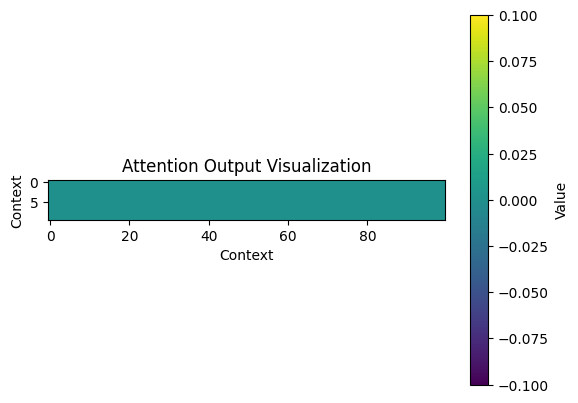

In [20]:
transform = Transformer(cfg)
print(x.shape)
output = transform(x)
print(output.shape)
# print(attn(x))
# print(mh_attn(x))

# visualize the attention scores
plt.imshow(output.detach().numpy()[:, :100], cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value")  # Add a color bar
plt.title("Attention Output Visualization")
plt.xlabel("Context")
plt.ylabel("Context")
plt.show()
# visualize the attention scores

torch.Size([10, 128])
torch.Size([10, 128])


C:\Users\logan\AppData\Local\Temp\ipykernel_11284\3266049027.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x))


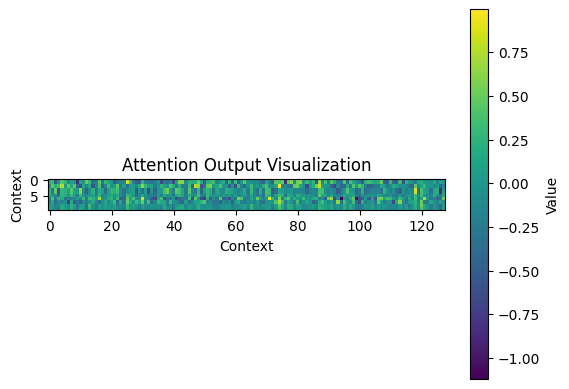

In [21]:
cfg = GPTConfig()

ah = AttentionHead(cfg)
x = torch.randn(10, cfg.d_model)
print(ah(x).shape)

output = ah.forward(x)
print(output.shape)


# visualize the attention scores
plt.imshow(output.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value")  # Add a color bar
plt.title("Attention Output Visualization")
plt.xlabel("Context")
plt.ylabel("Context")
plt.show()
# visualize the attention scores


In [22]:
#config
batch_size = 8
num_epochs = 1
lr = 1e-3
weight_decay = 1e-2
model_cfg = GPTConfig(d_model=128, d_vocab=10000, n_heads=4, n_layers=6, d_mlp=512)

In [23]:
#create data 
#dependincies
#pip install requests
#pip install torch
from get_books import get_many_books, get_gutenberg_book
from transformers import AutoTokenizer
import torch
from torch.utils.data import DataLoader, Dataset

#list of book IDs to download
book_ids = [84, 85, 86, 87, 88, 89, 90, 91, 92, 93]  

dataset = get_many_books(book_ids, data_temp="./data/gutenberg_data")

batch_size = 32  

class TextDataset(Dataset):
    def __init__(self, texts, max_length=512):
        self.texts = texts
        self.max_length = max_length
        self.tokenizer = AutoTokenizer.from_pretrained("gpt2")  # Initialize tokenizer once
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }

# Create dataset and dataloader
text_dataset = TextDataset(dataset)
dataloader = DataLoader(text_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Print first book to verify data loading
print(f"Loaded {len(dataset)} books")
print(f"First book preview: {dataset[0][:200]}...")



Getting book 84...
	426785 characters read
Getting book 84...
	359291 characters read
Getting book 84...
	656545 characters read
Getting book 84...
	2628536 characters read
Getting book 84...
	789503 characters read
Getting book 84...
	810978 characters read
Getting book 84...
	531109 characters read
Getting book 84...
	178879 characters read
Getting book 84...
	378503 characters read
Getting book 84...
	124228 characters read
Loaded 10 books
First book preview: 



Frankenstein;



or, the Modern Prometheus



by Mary Wollstonecraft (Godwin) Shelley





 CONTENTS



 Letter 1

 Letter 2

 Letter 3

 Letter 4

 Chapter 1

 Chapter 2

 Chapter 3

 Chapter 4

...


In [25]:
#create model
#pip uninstall torch torchvision torchaudio
#pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
import torch
model = Transformer(cfg)
model.to("cuda")  # Move model to GPU if available

AssertionError: Torch not compiled with CUDA enabled

In [26]:
import subprocess
result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
print(result.stdout)

Mon Mar  3 13:47:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.99                 Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0             22W /   80W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [27]:
import torch

# Check CUDA availability
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU device name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

# Initialize model with GPU/CPU handling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = Transformer(cfg)
model = model.to(device)

CUDA available: False
CUDA version: None
GPU device name: No GPU
Using device: cpu
